<center><h1>Custom-MLP</h1></center>
<center><h3>Implementing a Multi-Layer Perceptron (MLP) from scratch</h3></center>
<br>

## Imports

In [1]:
from utils import (
    set_global_datatype,
    print_confusion_matrix
)

from mnist_dataset import (
    load_raw_MNIST_dataset_from_disk,
    plot_random_images_from_raw_MNIST_dataset,
    format_raw_MNIST_dataset
)

from network import Network

from layers import (
    InputLayer,
    DenseLayer,
    ActivationLayer,
    BatchNormLayer,
    DropoutLayer
)

## Defining the datatype of *all* the data that will flow through the network

For now, the only accepted datatypes are `float32` and `float64` :

In [2]:
# = "float32" or "float64"
datatype = "float32"

In [3]:
set_global_datatype(datatype)

## Loading and formatting the data

The following seed is currently used to :
- Randomly split the raw data into the "train", "val" and "test" sets
- Randomly shuffle the "train", "val" and "test" sets

Set this seed to `None` for "real" randomness during those 2 processes :

In [4]:
seed_data_formatting = 555

Here, `selected_classes` can either be :
- The string `"all"` (if you want to work with all the digits ranging from `0` to `9`)
- A list/tuple/1D-array containing the specific digits you want to work with (e.g. `[2, 4, 7]`)

In [5]:
selected_classes = "all"

Defining the number of samples in the "train", "val" and "test" sets<br>
<ins>**NB**</ins> : The validation set is extracted from the raw "train" data, not from the raw "test" data. As a reminder, there are :
- 60000 samples in the raw "train" data **(if all the classes are selected)**
- 10000 samples in the raw "test" data **(if all the classes are selected)**

In [6]:
nb_train_samples = 10000
nb_val_samples   = 1000 # can be set to zero if needed
nb_test_samples  = 1000

Loading the raw data :

In [7]:
raw_X_train, raw_y_train, raw_X_test, raw_y_test = load_raw_MNIST_dataset_from_disk(
    verbose=True
)


Shapes of the raw MNIST data :
    - X_train : (60000, 28, 28)
    - y_train : (60000,)
    - X_test  : (10000, 28, 28)
    - y_test  : (10000,)

Types of the raw MNIST data :
    - X_train : numpy.uint8
    - y_train : numpy.uint8
    - X_test  : numpy.uint8
    - y_test  : numpy.uint8

Ranges of the raw MNIST data :
    - X_train : 0 -> 255
    - y_train : 0 -> 9
    - X_test  : 0 -> 255
    - y_test  : 0 -> 9

Class distributions :

y_train :
    0 --> 09.87 %
    1 --> 11.24 %
    2 --> 09.93 %
    3 --> 10.22 %
    4 --> 09.74 %
    5 --> 09.04 %
    6 --> 09.86 %
    7 --> 10.44 %
    8 --> 09.75 %
    9 --> 09.91 %
y_test :
    0 --> 09.80 %
    1 --> 11.35 %
    2 --> 10.32 %
    3 --> 10.10 %
    4 --> 09.82 %
    5 --> 08.92 %
    6 --> 09.58 %
    7 --> 10.28 %
    8 --> 09.74 %
    9 --> 10.09 %

The raw MNIST dataset was successfully loaded from the disk. Done in 0.378 seconds


Plotting random samples of each digit (from the raw data) :

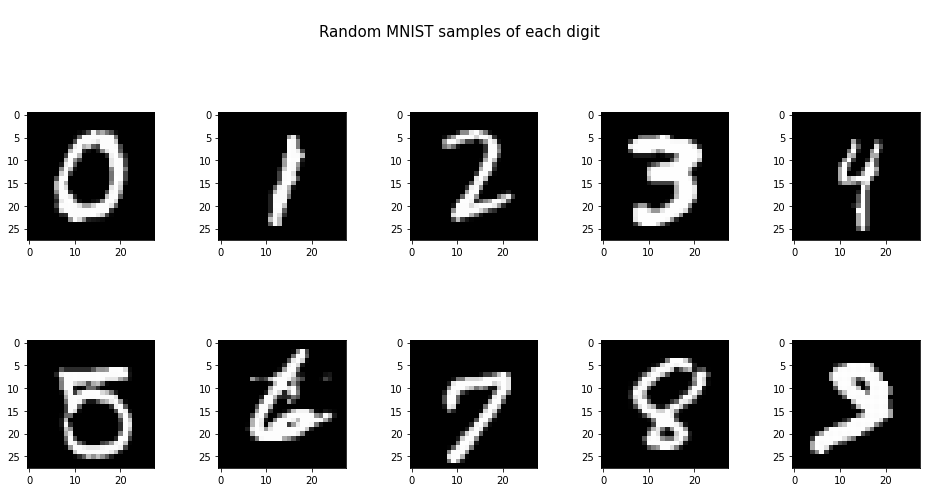

In [8]:
plot_random_images_from_raw_MNIST_dataset(
    raw_X_train,
    raw_y_train,
    raw_X_test,
    raw_y_test,
    seed=None
)

Formatting the raw data :

In [9]:
# NB : If you set `nb_val_samples` to zero, `X_val` and `y_val` will both
#      be equal to `None`
X_train, y_train, X_val, y_val, X_test, y_test = format_raw_MNIST_dataset(
    raw_X_train,
    raw_y_train,
    raw_X_test,
    raw_y_test,
    nb_train_samples,
    nb_val_samples,
    nb_test_samples,
    selected_classes=selected_classes,
    nb_shuffles=20,
    seed=seed_data_formatting,
    verbose=True
)


Shapes of the formatted MNIST data :
    - X_train : (10000, 784)
    - y_train : (10000, 10)
    - X_val   : (1000, 784)
    - y_val   : (1000, 10)
    - X_test  : (1000, 784)
    - y_test  : (1000, 10)

Types of the formatted MNIST data :
    - X_train : numpy.float32
    - y_train : numpy.float32
    - X_val   : numpy.float32
    - y_val   : numpy.float32
    - X_test  : numpy.float32
    - y_test  : numpy.float32

Ranges of the formatted MNIST data :
    - X_train : 0.000 -> 1.000 (mean=0.131, std=0.308)
    - y_train : 0.000 -> 1.000 (one-hot encoded)
    - X_val   : 0.000 -> 1.000 (mean=0.131, std=0.308)
    - y_val   : 0.000 -> 1.000 (one-hot encoded)
    - X_test  : 0.000 -> 1.000 (mean=0.132, std=0.310)
    - y_test  : 0.000 -> 1.000 (one-hot encoded)

Class distributions :

y_train :
    0 --> 09.87 %
    1 --> 11.24 %
    2 --> 09.93 %
    3 --> 10.22 %
    4 --> 09.74 %
    5 --> 09.03 %
    6 --> 09.86 %
    7 --> 10.44 %
    8 --> 09.75 %
    9 --> 09.92 %
y_val :
    0 

Defining the input and output sizes of the network (respectively) :

In [10]:
# = 28 * 28 = 784 pixels per image
nb_pixels_per_image = X_train.shape[1]
nb_pixels_per_image

784

In [11]:
# = number of (distinct) selected digits
nb_classes = y_train.shape[1]
nb_classes

10

## Defining the hyperparameters of the Multi-Layer Perceptron (MLP) network

The following seed is currently used to :<br>
- Randomly initialize the weights and biases of the Dense layers
- Randomly generate the dropout matrices of the Dropout layers (if these layers are used)
- Randomly split the training data into batches during the training phase (at each epoch)

Set this seed to `None` for "real" randomness during those 3 processes :

In [12]:
seed_network = 7777

Main hyperparameters :

In [13]:
nb_epochs = 10
learning_rate = 0.15

# if you lower the batch size, you might also want to lower the learning
# rate (to prevent the network from overfitting)
train_batch_size = 40

nb_neurons_in_hidden_dense_layers = [
    256,
    64,
    32
]

The BatchNorm layer is a regularization layer that helps prevent overfitting (without necessarily improving the overall accuracy of the network). It basically standardizes (i.e. it normalizes with a mean of 0 and a standard deviation of 1) the outputs of the previous layer, and then applies an affine transform to the standardized outputs. The 2 parameters of the affine transform (typically called `gamma` and `beta`) are the trainable parameters of the layer :

In [14]:
use_batch_norm_layers = False

Just like the BatchNorm layer, the Dropout layer is a regularization layer that helps prevent overfitting, without necessarily improving the overall accuracy of the network. Basically, it randomly sets input values to 0 with a frequency of `dropout_rate` at each step during the training phase. This layer doesn't have any trainable parameters :

In [15]:
use_dropout_layers = False
dropout_rate = 0.10

## Building the MLP network architecture from the previously defined hyperparameters

### Initializing the network

If you set `normalize_input_data` to `True`, every time the data will be split into batches (during the training, validation AND testing phases), each resulting batch will be normalized such that its mean is 0 and its standard deviation is 1. It's HIGHLY recommended to set `normalize_input_data` to `True` here, in order to have better performances :

In [16]:
network = Network(normalize_input_data=True)

Input layer :

In [17]:
network.add(InputLayer(input_size=nb_pixels_per_image))

### Hidden layers

In [18]:
seed = seed_network

for hidden_layer_index, nb_neurons in enumerate(nb_neurons_in_hidden_dense_layers):
    network.add(DenseLayer(nb_neurons, seed=seed))
    
    if use_batch_norm_layers:
        # Adding a BatchNorm regularization layer (if requested)
        network.add(BatchNormLayer())
    
    """
    Possible relevant choices here (the activation name is case insensitive) :
        network.add(ActivationLayer("ReLU"))
        OR
        network.add(ActivationLayer("leaky_ReLU", leaky_ReLU_coeff=0.01))
        OR
        network.add(ActivationLayer("tanh"))
    """
    network.add(ActivationLayer("ReLU"))
    
    if use_dropout_layers:
        # Adding a Dropout regularization layer (if requested)
        network.add(DropoutLayer(dropout_rate, seed=seed))
    
    if seed is not None:
        # updating the seed such that the "randomness" in the added
        # Dense/Dropout layers is different each time (in case 2
        # consecutive values of `nb_neurons` are the same)
        seed += 1

### Output layers

In [19]:
if seed_network is not None:
    assert seed == seed_network + len(nb_neurons_in_hidden_dense_layers)

network.add(DenseLayer(nb_classes, seed=seed))

"""
Possible relevant choices here (the activation name is case insensitive) :
    network.add(ActivationLayer("softmax"))
    OR
    network.add(ActivationLayer("sigmoid"))
"""
network.add(ActivationLayer("softmax"))

### Displaying the summary of the network's architecture

In [20]:
# NB : The kwargs of this method will only affect how the summary will look
#      like when it's printed (they won't affect the summary's contents)
network.summary(
    initial_spacing=1,
    column_separator="|", # can be multiple characters long
    row_separator="-",    # has to be a single character
    bounding_box="*"      # has to be a single character
)

# Or, equivalently, you can run : `print(network)`


 *****************************************************************************************
 *                                                                                       *
 *                                    NETWORK SUMMARY                                    *
 *                                                                                       *
 *    Layer                  |  Input shape  |  Output shape  |  Trainable parameters    *
 *    -----------------------|---------------|----------------|----------------------    *
 *    Input(784)             |  (None, 784)  |  (None, 784)   |  0                       *
 *    Dense(256)             |  (None, 784)  |  (None, 256)   |  200,960                 *
 *    Activation("relu")     |  (None, 256)  |  (None, 256)   |  0                       *
 *    Dense(64)              |  (None, 256)  |  (None, 64)    |  16,448                  *
 *    Activation("relu")     |  (None, 64)   |  (None, 64)    |  0                       

## Setting the loss function of the network

In [21]:
"""
Possible relevant choices here (the loss function name is case insensitive) :
    network.set_loss_function("CCE") # CCE = Categorical Cross-Entropy
    OR
    network.set_loss_function("MSE") # MSE = Mean Squared Error
"""
network.set_loss_function("CCE")

## Training phase

<ins>**NB**</ins> : Here, inputting validation data is **optional**. If you don't want to use validation data, please (at least) set the `validation_data` kwarg to `None` (or don't specify it at all). If you set `nb_val_samples` to zero, the validation kwargs will automatically be discarded :

In [22]:
if nb_val_samples > 0:
    validation_kwargs = {
        "validation_data" : (X_val, y_val),
        "val_batch_size"  : 32
    }
else:
    validation_kwargs = {}

In [23]:
network.fit(
    X_train,
    y_train,
    nb_epochs,
    train_batch_size,
    learning_rate,
    nb_shuffles_before_each_train_batch_split=10,
    seed_train_batch_splits=seed_network,
    **validation_kwargs
)


# ------------------------------------------------------------------------------------------------------------- #

     Starting the training loop ...

     epoch 01/10  -  train_loss=0.7628  -  val_loss=0.3797  -  train_accuracy=0.7723  -  val_accuracy=0.8810                                          
     epoch 02/10  -  train_loss=0.2685  -  val_loss=0.2848  -  train_accuracy=0.9241  -  val_accuracy=0.9150                                          
     epoch 03/10  -  train_loss=0.1923  -  val_loss=0.2737  -  train_accuracy=0.9519  -  val_accuracy=0.9220                                          
     epoch 04/10  -  train_loss=0.1484  -  val_loss=0.2072  -  train_accuracy=0.9645  -  val_accuracy=0.9390                                          
     epoch 05/10  -  train_loss=0.1181  -  val_loss=0.2109  -  train_accuracy=0.9736  -  val_accuracy=0.9360                                          
     epoch 06/10  -  train_loss=0.0975  -  val_loss=0.1852  -  train_accuracy=0.9812  -  val

## RESULTS

Plotting the network's history :

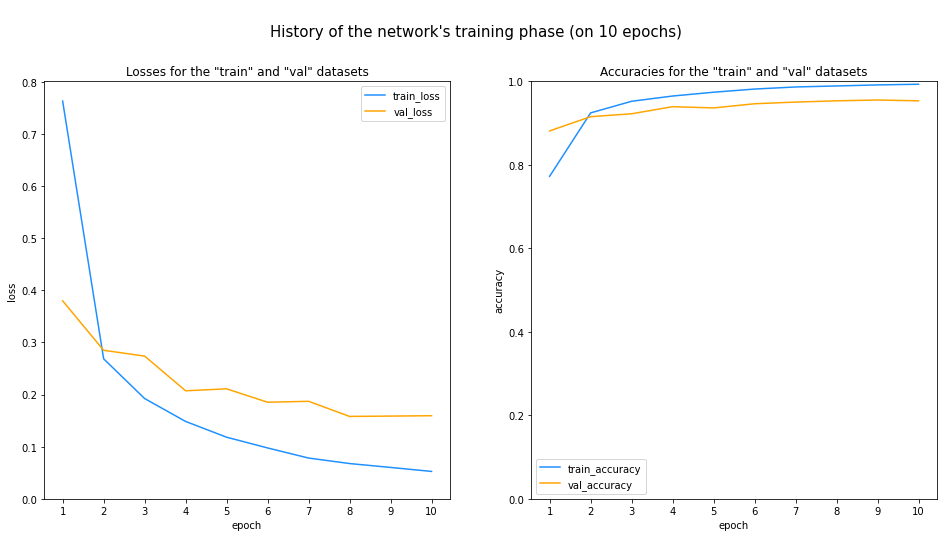

In [24]:
network.plot_history(
    save_plot_to_disk=False,
    saved_image_name="network_history" # it will be saved as a PNG image by default
)

The "top-N accuracy" is defined as the proportion of the true classes that lie within the `N` most probable predicted classes (here, `N` is actually `top_N_accuracy`) :

In [25]:
top_N_accuracy = 2

Computing the global accuracy scores, the testing loss and the (raw) confusion matrix of the network :

In [26]:
acc_score, top_N_acc_score, test_loss, conf_matrix = network.evaluate(
    X_test,
    y_test,
    top_N_accuracy=top_N_accuracy,
    test_batch_size=32
)

Displaying the **raw** confusion matrix of the network :

In [27]:
# NB : When you load this notebook for the first time, the diagonal won't be
#      highlighted in green (the output will be the unstyled confusion matrix).
#      Simply re-run the entire notebook to see the highlighting of the diagonal !
print_confusion_matrix(
    conf_matrix,
    selected_classes=selected_classes,
    normalize="no", # = "rows", "columns" or "no"
    jupyter_notebook=True,
    color="green" # = "green", "blue", "purple", "red" or "orange"
)


CONFUSION MATRIX (normalized="no") :


ACTUAL,0,1,2,3,4,5,6,7,8,9
PREDICTED,,,,,,,,,,
0,95,0,1,0,0,0,0,0,1,1
1,1,114,0,1,0,0,0,0,0,2
2,0,0,99,1,2,0,0,1,2,1
3,0,0,0,93,0,0,0,0,1,0
4,0,0,0,0,94,0,0,0,0,0
5,0,0,0,3,0,87,0,1,1,1
6,1,0,0,0,1,1,96,0,0,0
7,0,0,1,2,0,0,0,101,1,0
8,0,0,2,1,0,1,0,0,90,0


Displaying the **precision** of the network (i.e. the confusion matrix with normalized **rows**) :

In [28]:
# NB : When you load this notebook for the first time, the diagonal won't be
#      highlighted in green (the output will be the unstyled confusion matrix).
#      Simply re-run the entire notebook to see the highlighting of the diagonal !
print_confusion_matrix(
    conf_matrix,
    selected_classes=selected_classes,
    normalize="rows", # = "rows", "columns" or "no"
    precision=1,
    jupyter_notebook=True,
    color="green" # = "green", "blue", "purple", "red" or "orange"
)


CONFUSION MATRIX (normalized="rows") :


ACTUAL,0,1,2,3,4,5,6,7,8,9
PREDICTED,,,,,,,,,,
0,96.9 %,0.0 %,1.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,1.0 %,1.0 %
1,0.8 %,96.6 %,0.0 %,0.8 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,1.7 %
2,0.0 %,0.0 %,93.4 %,0.9 %,1.9 %,0.0 %,0.0 %,0.9 %,1.9 %,0.9 %
3,0.0 %,0.0 %,0.0 %,98.9 %,0.0 %,0.0 %,0.0 %,0.0 %,1.1 %,0.0 %
4,0.0 %,0.0 %,0.0 %,0.0 %,100.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %
5,0.0 %,0.0 %,0.0 %,3.2 %,0.0 %,93.5 %,0.0 %,1.1 %,1.1 %,1.1 %
6,1.0 %,0.0 %,0.0 %,0.0 %,1.0 %,1.0 %,97.0 %,0.0 %,0.0 %,0.0 %
7,0.0 %,0.0 %,1.0 %,1.9 %,0.0 %,0.0 %,0.0 %,96.2 %,1.0 %,0.0 %
8,0.0 %,0.0 %,2.1 %,1.1 %,0.0 %,1.1 %,0.0 %,0.0 %,95.7 %,0.0 %


Displaying the **recall** of the network (i.e. the confusion matrix with normalized **columns**) :

In [29]:
# NB : When you load this notebook for the first time, the diagonal won't be
#      highlighted in green (the output will be the unstyled confusion matrix).
#      Simply re-run the entire notebook to see the highlighting of the diagonal !
print_confusion_matrix(
    conf_matrix,
    selected_classes=selected_classes,
    normalize="columns", # = "rows", "columns" or "no"
    precision=1,
    jupyter_notebook=True,
    color="green" # = "green", "blue", "purple", "red" or "orange"
)


CONFUSION MATRIX (normalized="columns") :


ACTUAL,0,1,2,3,4,5,6,7,8,9
PREDICTED,,,,,,,,,,
0,96.9 %,0.0 %,1.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,1.0 %,1.0 %
1,1.0 %,100.0 %,0.0 %,1.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,2.0 %
2,0.0 %,0.0 %,96.1 %,1.0 %,2.0 %,0.0 %,0.0 %,1.0 %,2.1 %,1.0 %
3,0.0 %,0.0 %,0.0 %,92.1 %,0.0 %,0.0 %,0.0 %,0.0 %,1.0 %,0.0 %
4,0.0 %,0.0 %,0.0 %,0.0 %,95.9 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %
5,0.0 %,0.0 %,0.0 %,3.0 %,0.0 %,97.8 %,0.0 %,1.0 %,1.0 %,1.0 %
6,1.0 %,0.0 %,0.0 %,0.0 %,1.0 %,1.1 %,100.0 %,0.0 %,0.0 %,0.0 %
7,0.0 %,0.0 %,1.0 %,2.0 %,0.0 %,0.0 %,0.0 %,98.1 %,1.0 %,0.0 %
8,0.0 %,0.0 %,1.9 %,1.0 %,0.0 %,1.1 %,0.0 %,0.0 %,92.8 %,0.0 %


Displaying the testing loss and the global accuracy scores of the network :

In [30]:
precision_loss = 4 # by default
print(f"\nTESTING LOSS    : {test_loss:.{precision_loss}f}")

precision_accuracy = 2 # by default
print(f"\nGLOBAL ACCURACY : {acc_score:.{precision_accuracy}f} %")
potential_extra_space = " " * int(top_N_accuracy < 10)
print(f"TOP-{top_N_accuracy}{potential_extra_space} ACCURACY : {top_N_acc_score:.{precision_accuracy}f} %\n")


TESTING LOSS    : 0.1387

GLOBAL ACCURACY : 96.50 %
TOP-2  ACCURACY : 98.60 %



Displaying some of the network's predictions (for testing purposes only) :

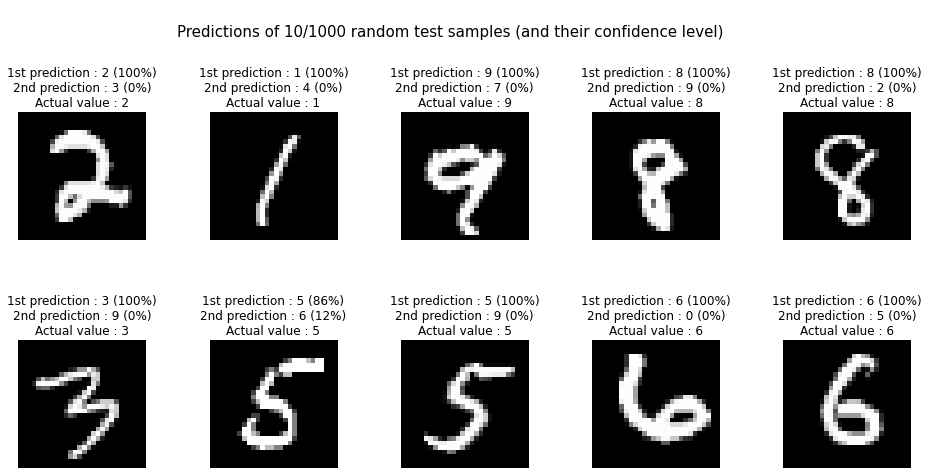

In [31]:
network.display_some_predictions(
    X_test,
    y_test,
    selected_classes=selected_classes,
    seed=None
)

<center><h2>END</h2></center>